# Mini projekt finansowy

#### 4 tabele tj:
 * Kategorie - `id, nazwa kategorii, typ tj przychód lub koszt`
 * klienci - `id, nazwa_klienta, nip, email, telefon, miasto`
 * transakcje - `id transakcji, id klienta, id kategorii, data, numer dokumentu, kwota netto, stawka vat, kwota vat, kwota brutto, opis`
 * płatności - `id_platnosci, id_transakcji, data_platnosci, kwota, forma_platnosci`

### Importy i Połączenie

In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import random
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Connect to database

USER = 'marcin'
PASSWORD = '1234'
HOST = 'localhost'
PORT = '5432'
DATABASE = 'finanse_test'

connection_string = f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}'
engine = create_engine(connection_string)

### Create datatables

In [23]:
sql_create_table_kategorie = """
CREATE TABLE IF NOT EXISTS kategorie (
    category_id SERIAL PRIMARY KEY,
    name VARCHAR(50) NOT NULL,
    type VARCHAR(10) NOT NULL CHECK (type IN ('COST', 'REVENUE'))
);
"""

sql_create_table_klienci = """
CREATE TABLE IF NOT EXISTS klienci (
    client_id SERIAL PRIMARY KEY,
    name VARCHAR(255) NOT NULL CHECK(LENGTH(name) > 3),
    nip VARCHAR(10) UNIQUE NOT NULL CHECK(LENGTH(nip) = 10),
    email VARCHAR(100),
    phone VARCHAR(20),
    city VARCHAR(125)
);
"""

sql_create_table_transakcje = """
CREATE TABLE IF NOT EXISTS transakcje (
    transaction_id SERIAL PRIMARY KEY,
    client_id INTEGER NOT NULL REFERENCES klienci(client_id),
    category_id INTEGER NOT NULL REFERENCES kategorie(category_id),
    date DATE NOT NULL,
    document_number VARCHAR(50) UNIQUE NOT NULL,
    cost_netto NUMERIC(10, 2) NOT NULL,
    vat_rate NUMERIC(4, 2) NOT NULL,
    cost_vat NUMERIC(10, 2) NOT NULL,
    cost_brutto NUMERIC(10, 2) NOT NULL,
    description VARCHAR(255),
    status VARCHAR(20) DEFAULT 'Unpaid' CHECK(status IN('Paid', 'Unpaid', 'Overdue')),
    CHECK (cost_brutto = cost_netto + cost_vat)
);
"""

sql_create_table_platnosci = """
CREATE TABLE IF NOT EXISTS platnosci (
    payment_id SERIAL PRIMARY KEY,
    transaction_id INTEGER NOT NULL REFERENCES transakcje(transaction_id),
    payment_date DATE NOT NULL,
    amount NUMERIC(10, 2) NOT NULL,
    payment_method VARCHAR(50) NOT NULL
);
"""

In [15]:
def execute_query(query):
    with engine.connect() as conn:
        try:
            conn.execute(text(query))
            conn.commit()
            print('Query executed Succesfully!')
        except Exception as e:
            conn.rollback()
            print(e)

In [24]:
execute_query(sql_create_table_kategorie)
execute_query(sql_create_table_klienci)
execute_query(sql_create_table_transakcje)
execute_query(sql_create_table_platnosci)

Query executed Succesfully!
Query executed Succesfully!
Query executed Succesfully!
Query executed Succesfully!


### Generating Data

In [26]:
df_kategorie = pd.DataFrame({
    'name': ['Sprzedaż towarów', 'Usługi', 'Odsetki', 'Inne przychody', 'Wynagrodzenie', 'Czynsz',
             'Zakup towarów', 'Media', 'Marketing'],
    'type': ['REVENUE', 'REVENUE', 'REVENUE', 'REVENUE', 'COST', 'COST', 'COST', 'COST', 'COST']
})
df_kategorie.head()

,name,type
0,Sprzedaż towarów,REVENUE
1,Usługi,REVENUE
2,Odsetki,REVENUE
3,Inne przychody,REVENUE
4,Wynagrodzenie,COST


In [ ]:
try:
    df_kategorie.to_sql('kategorie', engine, if_exists='append', index=False)
    print('Succesfully added data')
except Exception as e:
    print(e)

In [52]:
n_klientów = 50

def return_nip():
    return ''.join(str(random.randint(0, 9)) for _ in range(10))

def return_email():
    return

df_klienci = pd.DataFrame({
    'name': [f"Firma {i} Sp.z.o.o." for i in range(n_klientów)],
    'nip': [return_nip() for _  in range(n_klientów)],
    'email': [f"Firma{i}@gmail.com" for i in range(n_klientów)],
    'phone': [f'+48 {random.randint(500_000_000, 999_999_999)}' for _ in range(n_klientów)],
    'city': [random.choice(['Warszawa', 'Kraków', 'Gdańsk', 'Poradzew', 'New York', 'California', 'Poznan']) for _ in range(n_klientów)]
})

df_klienci.head()

,name,nip,email,phone,city
0,Firma 0 Sp.z.o.o.,8287248352,Firma0@gmail.com,+48 676243660,California
1,Firma 1 Sp.z.o.o.,3591586609,Firma1@gmail.com,+48 988126898,New York
2,Firma 2 Sp.z.o.o.,1631071928,Firma2@gmail.com,+48 783915718,Kraków
3,Firma 3 Sp.z.o.o.,6263331596,Firma3@gmail.com,+48 610448244,Warszawa
4,Firma 4 Sp.z.o.o.,1008314225,Firma4@gmail.com,+48 660962887,Kraków


In [53]:
try:
    df_klienci.to_sql('klienci', engine, if_exists='append', index=False)
    print('Succesfully added data')
except Exception as e:
    print(e)

Succesfully added data


In [60]:
n_transakcji = 1000

# Daty
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31)
date_range = (end_date - start_date).days

dates = [start_date + timedelta(days=np.random.randint(0, date_range)) for _ in range(n_transakcji)]
dates.sort()  # Sortuj chronologicznie

df_transakcje = pd.DataFrame({
    'client_id': np.random.randint(1, n_klientów+1, n_transakcji),  # 1-50
    'category_id': np.random.randint(1, 10, n_transakcji),  # 1-9 (bo masz 9 kategorii)
    'date': dates,
    'document_number': [f'FV/{d.year}/{d.month:02d}/{i+1:04d}' for i, d in enumerate(dates)],
    'cost_netto': np.random.uniform(100, 50000, n_transakcji).round(2),
    'vat_rate': np.random.choice([0.23, 0.08, 0.00], n_transakcji, p=[0.7, 0.2, 0.1]),
    'status': np.random.choice(['Paid', 'Unpaid'], n_transakcji, p=[0.7, 0.3]),
    'description': 'Transakcja handlowa'
})

# Oblicz VAT i brutto
df_transakcje['cost_vat'] = (df_transakcje['cost_netto'] * df_transakcje['vat_rate']).round(2)
df_transakcje['cost_brutto'] = (df_transakcje['cost_netto'] + df_transakcje['cost_vat']).round(2)

print("\nTransakcje (pierwsze 5):")
print(df_transakcje.head())


Transakcje (pierwsze 5):
   client_id  category_id       date  document_number  cost_netto  vat_rate  \
0         18            7 2023-01-01  FV/2023/01/0001     3880.33      0.23   
1         30            2 2023-01-01  FV/2023/01/0002    14490.25      0.23   
2         28            6 2023-01-01  FV/2023/01/0003     2440.67      0.23   
3         30            6 2023-01-01  FV/2023/01/0004    27014.25      0.00   
4         16            5 2023-01-03  FV/2023/01/0005    29983.35      0.08   

   status          description  cost_vat  cost_brutto  
0  Unpaid  Transakcja handlowa    892.48      4772.81  
1    Paid  Transakcja handlowa   3332.76     17823.01  
2    Paid  Transakcja handlowa    561.35      3002.02  
3    Paid  Transakcja handlowa      0.00     27014.25  
4  Unpaid  Transakcja handlowa   2398.67     32382.02  


In [66]:
try:
    df_transakcje.to_sql('transakcje', engine, if_exists='append', index=False)
    print('Succesfully added data')
except Exception as e:
    print(e)

Succesfully added data


In [67]:
paid_transactions = df_transakcje[df_transakcje['status'] == 'Paid'].copy()
paid_transactions['transaction_id'] = range(1, len(paid_transactions) + 1)  # Tymczasowe ID

platnosci_list = []

for _, row in paid_transactions.iterrows():
    # Data płatności: 5-30 dni po transakcji
    payment_date = row['date'] + timedelta(days=np.random.randint(5, 31))
    
    platnosci_list.append({
        'transaction_id': row['transaction_id'],
        'payment_date': payment_date,
        'amount': row['cost_brutto'],
        'payment_method': np.random.choice(['Przelew', 'Gotówka', 'Karta'], p=[0.8, 0.1, 0.1])
    })

df_platnosci = pd.DataFrame(platnosci_list)

print(df_platnosci.head())

   transaction_id payment_date    amount payment_method
0               1   2023-01-19  17823.01        Przelew
1               2   2023-01-20   3002.02        Przelew
2               3   2023-01-24  27014.25        Przelew
3               4   2023-01-09    567.20        Przelew
4               5   2023-01-17   7888.21        Przelew


In [68]:
try:
    df_platnosci.to_sql('platnosci', engine, if_exists='append', index=False)
    print('Succesfully added data')
except Exception as e:
    print(e)

Succesfully added data


### Raport 1

In [89]:
def sum_by_category():

    query = """
    SELECT
        c.name,
        c.type,
        SUM(t.cost_brutto) AS amount,
        COUNT(*) AS transaction_count
    FROM
        transakcje t
    LEFT JOIN kategorie c ON t.category_id = c.category_id

    GROUP BY c.name, c.type

    ORDER BY amount DESC
    """
    try:
        return pd.read_sql(query, engine)
    except Exception as e:
        print(e)

df_sum_by_category = sum_by_category()
df_sum_by_category.head(10)



,name,type,amount,transaction_count
0,Zakup towarów,COST,3489997.87,132
1,Sprzedaż towarów,REVENUE,3485391.50,113
2,Marketing,COST,3481051.73,116
3,Wynagrodzenie,COST,3463081.86,120
4,Inne przychody,REVENUE,3309113.04,114
5,Czynsz,COST,3173286.43,107
6,Odsetki,REVENUE,3083095.36,100
7,Media,COST,3016260.92,98
8,Usługi,REVENUE,2808516.13,100


In [110]:
def bilans():
    query = """
    SELECT
        SUM(CASE WHEN k.type = 'REVENUE' THEN t.cost_brutto ELSE 0 END) AS sum_of_revenue,
        SUM(CASE WHEN k.type = 'COST' THEN t.cost_brutto ELSE 0 END) AS sum_of_cost,
        (SUM(CASE WHEN k.type = 'REVENUE' THEN t.cost_brutto ELSE 0 END) - 
        SUM(CASE WHEN k.type = 'COST' THEN t.cost_brutto ELSE 0 END)) AS bilans
    FROM
        transakcje t
    JOIN kategorie k ON t.category_id = k.category_id
    """

    try:
        return pd.read_sql(query, engine)
    except Exception as e:
        print(e)

bilans().head()

,sum_of_revenue,sum_of_cost,bilans
0,12686116.03,16623678.81,-3937562.78


### RAPORT 2

In [136]:
def top_10_clients():
    query = """
    SELECT
        c.name,
        c.nip,
        SUM(t.cost_brutto) AS client_amount,
        COUNT(*) AS transactions,
        ROUND(SUM(t.cost_brutto) / COUNT(*), 2) AS average,
        ROUND((SUM(t.cost_brutto) / SUM(SUM(t.cost_brutto)) OVER ()) *100, 3) AS perc_of_total

    FROM transakcje t
    JOIN kategorie k ON t.category_id = k.category_id
    JOIN klienci c ON t.client_id = c.client_id
    WHERE k.type = 'REVENUE'
    GROUP BY c.name, c.nip
    ORDER BY client_amount DESC
    LIMIT 10
    """

    try:
        return pd.read_sql(query, engine)
    except Exception as e:
        print(e)

top_10_clients().head(20)

,name,nip,client_amount,transactions,average,perc_of_total
0,Firma 15 Sp.z.o.o.,4566272764,515025.08,16,32189.07,4.060
1,Firma 41 Sp.z.o.o.,1952402730,494933.89,13,38071.84,3.901
2,Firma 48 Sp.z.o.o.,9848436421,475961.92,13,36612.46,3.752
3,Firma 31 Sp.z.o.o.,1463624088,451605.05,12,37633.75,3.560
4,Firma 6 Sp.z.o.o.,1683622430,391429.55,10,39142.96,3.085
5,Firma 27 Sp.z.o.o.,6267891234,390946.69,10,39094.67,3.082
6,Firma 44 Sp.z.o.o.,8995422478,371698.87,11,33790.81,2.930
7,Firma 3 Sp.z.o.o.,6263331596,370453.70,9,41161.52,2.920
8,Firma 8 Sp.z.o.o.,1193469050,327552.42,11,29777.49,2.582
9,Firma 10 Sp.z.o.o.,9204309500,325507.00,12,27125.58,2.566


### RAPORT 3

In [180]:
def monthly_report():
    query = """
    SELECT 
        EXTRACT(YEAR FROM date) AS year,
        EXTRACT(MONTH FROM date) AS month,
        COUNT(*) AS transactions,
        SUM(cost_netto) AS netto_amount,
        SUM(cost_vat) AS vat_amount,
        SUM(cost_brutto) AS brutto_amount,

        ROUND(
            100.0*(SUM(cost_brutto) - LAG(SUM(cost_brutto)) OVER (ORDER BY 
                EXTRACT(YEAR FROM date),
                EXTRACT(MONTH FROM date)
            )) /
            LAG(SUM(cost_brutto)) OVER (ORDER BY 
                EXTRACT(YEAR FROM date),
                EXTRACT(MONTH FROM date)
                ), 2
        ) AS perc_difference
        
    FROM transakcje
    WHERE EXTRACT(YEAR FROM date) = 2024
    GROUP BY year, month
    ORDER BY month ASC
    """

    try:
        return pd.read_sql(query, engine)
    except Exception as e:
        print(e)

monthly_report().head(20)

,year,month,transactions,netto_amount,vat_amount,brutto_amount,perc_difference
0,2024.0,1.0,43,1132460.17,227330.51,1359790.68,NaN
1,2024.0,2.0,38,1040403.89,172956.79,1213360.68,-10.77
2,2024.0,3.0,45,1081238.61,173427.99,1254666.60,3.40
3,2024.0,4.0,33,659912.26,122575.09,782487.35,-37.63
4,2024.0,5.0,50,1224437.00,231095.98,1455532.98,86.01
5,2024.0,6.0,48,1256339.59,243874.93,1500214.52,3.07
6,2024.0,7.0,46,1287600.52,221800.85,1509401.37,0.61
7,2024.0,8.0,43,1111870.97,195984.61,1307855.58,-13.35
8,2024.0,9.0,51,1207739.93,172374.33,1380114.26,5.52
9,2024.0,10.0,33,715795.05,115535.93,831330.98,-39.76


### RAPORT 4

In [195]:
def unpaid_transactions():
    query = """
    SELECT
        c.name,
        c.nip,
        COUNT(*) as unpaid_transactions,
        SUM(t.cost_brutto) AS unpaid_amount,
        MIN(date) AS oldest_invoice_date,
        CURRENT_DATE - MIN(date) AS days_delayed

    FROM transakcje t
    JOIN klienci c ON t.client_id = c.client_id
    WHERE t.status = 'Unpaid'
    GROUP BY c.name, c.nip
    ORDER BY unpaid_amount DESC
    """

    try:
        return pd.read_sql(query, engine)
    except Exception as e:
        print(e)

unpaid_transactions().head()

,name,nip,unpaid_transactions,unpaid_amount,oldest_invoice_date,days_delayed
0,Firma 48 Sp.z.o.o.,9848436421,13,465545.11,2023-06-04,903
1,Firma 3 Sp.z.o.o.,6263331596,9,348846.51,2023-01-03,1055
2,Firma 36 Sp.z.o.o.,7861163522,9,341741.25,2023-01-27,1031
3,Firma 5 Sp.z.o.o.,1747089136,9,294404.22,2023-05-21,917
4,Firma 15 Sp.z.o.o.,4566272764,10,281486.50,2023-01-03,1055


### RAPORT 5

In [4]:
def trend_report():
    query = """
    SELECT 

        EXTRACT(MONTH FROM t.date) AS month,
        SUM(CASE WHEN EXTRACT(YEAR FROM t.date) = 2023 THEN t.cost_brutto END) AS sum_2023,
        SUM(CASE WHEN EXTRACT(YEAR FROM t.date) = 2024 THEN t.cost_brutto END) AS sum_2024,

        (SUM(CASE WHEN EXTRACT(YEAR FROM t.date) = 2024 THEN t.cost_brutto END) -
        SUM(CASE WHEN EXTRACT(YEAR FROM t.date) = 2023 THEN t.cost_brutto END)) AS difference,

        ROUND(
            100 * (SUM(CASE WHEN EXTRACT(YEAR FROM t.date) = 2024 THEN t.cost_brutto END) -
            SUM(CASE WHEN EXTRACT(YEAR FROM t.date) = 2023 THEN t.cost_brutto END)) /
            SUM(CASE WHEN EXTRACT(YEAR FROM t.date) = 2023 THEN t.cost_brutto END), 2
        ) AS perc_difference



    FROM transakcje t
    JOIN kategorie k ON t.category_id = k.category_id
    
    WHERE 
        (k.type = 'REVENUE' AND
        EXTRACT(YEAR FROM t.date) IN (2023, 2024))
    
        GROUP BY month
    """

    try:
        return pd.read_sql(query, engine)
    except Exception as e:
        print(e)

df_trend = trend_report()
df_trend.head(20)

,month,sum_2023,sum_2024,difference,perc_difference
0,1.0,683238.67,568914.04,-114324.63,-16.73
1,2.0,469822.07,758708.04,288885.97,61.49
2,3.0,493383.90,574934.85,81550.95,16.53
3,4.0,378523.21,360063.25,-18459.96,-4.88
4,5.0,374681.51,465893.18,91211.67,24.34
5,6.0,539275.66,812252.39,272976.73,50.62
6,7.0,514409.24,766802.11,252392.87,49.06
7,8.0,524240.09,464199.75,-60040.34,-11.45
8,9.0,463757.96,329256.75,-134501.21,-29.00
9,10.0,796700.21,319315.09,-477385.12,-59.92


<Axes: >

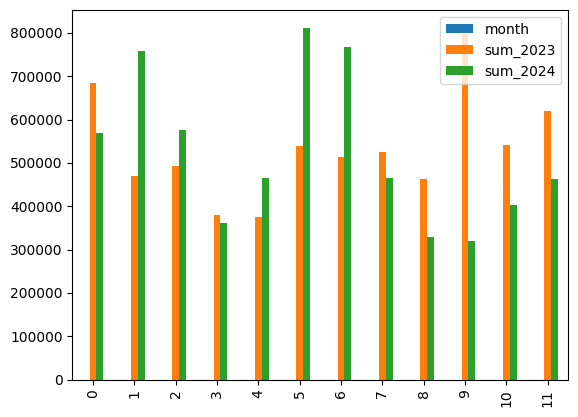

In [14]:
df_trend[['month', 'sum_2023', 'sum_2024']].plot(kind='bar')

In [12]:
df_trend[['month', 'sum_2023']]

,month,sum_2023
0,1.0,683238.67
1,2.0,469822.07
2,3.0,493383.90
3,4.0,378523.21
4,5.0,374681.51
5,6.0,539275.66
6,7.0,514409.24
7,8.0,524240.09
8,9.0,463757.96
9,10.0,796700.21
